In [34]:
# 原文：http://pytorch123.com/ThirdSection/TransferLearning/
# 迁移学习
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [10]:
# 训练集数据扩充和归一化
# 在验证集上仅需要归一化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), #随机裁剪一个area然后再resize
        transforms.RandomHorizontalFlip(), #随机水平翻转
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
# 还记得之前在data_load_and_handle中提到的ImageFolder么，这里的数据就是符合该规则的，可以直接读入不用再写Dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

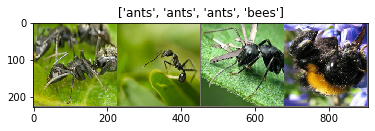

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# 获取一批训练数据
inputs, classes = next(iter(dataloaders['train']))

# 批量制作网格
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
# 编写一个通用函数来训练模型。下面将说明： * 调整学习速率 * 保存最好的模型
# 下面的参数scheduler是一个来自 torch.optim.lr_scheduler的学习速率调整类的对象(LR scheduler object)。

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 零参数梯度
                optimizer.zero_grad()

                # 前向
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # 返回outputs中每一行的最大值的下标，第二个参数表示维度，这里为1，即每一行的最大值返回数据第一个为值向量，第二个为下标向量
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 后向+仅在训练阶段进行优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase] #怎么乘了又除的
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 深度复制mo，这里就是把目前再验证集上效果最好的权重保存下来
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# 可视化模型预测结果

In [20]:
#一个通用的展示少量预测图片的函数
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [21]:
# 场景1：微调ConvNet
# 加载预训练模型并重置最终完全连接的图层。

In [22]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 相当于直接把最后一层变成2分类
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 观察所有参数都正在优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个epochs衰减LR通过设置gamma=0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Administrator/.cache\torch\checkpoints\resnet18-5c106cde.pth


In [23]:
# 训练和评估模型
#（1）训练模型 该过程在CPU上需要大约15-25分钟，但是在GPU上，它只需不到一分钟。

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6263 Acc: 0.6967
val Loss: 0.3598 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.6143 Acc: 0.7131
val Loss: 0.2237 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.3498 Acc: 0.8730
val Loss: 0.3090 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.7284 Acc: 0.7459
val Loss: 0.5476 Acc: 0.7843

Epoch 4/24
----------
train Loss: 0.4170 Acc: 0.8566
val Loss: 0.3144 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4970 Acc: 0.8156
val Loss: 0.4016 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.3749 Acc: 0.8402
val Loss: 0.2547 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3508 Acc: 0.8566
val Loss: 0.2319 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.2630 Acc: 0.8975
val Loss: 0.2305 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3754 Acc: 0.8566
val Loss: 0.2229 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2780 Acc: 0.8811
val Loss: 0.2272 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.4105 Acc: 0.8197
val Loss: 0.1928 Acc: 0.9346

Epoch 12/24
----------
t

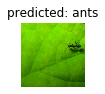

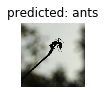

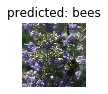

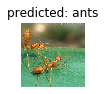

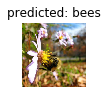

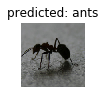

In [25]:
# 评估
visualize_model(model_ft)

In [26]:
# 场景2：ConvNet作为固定特征提取器
# 在这里需要冻结除最后一层之外的所有网络。通过设置requires_grad == False来冻结参数，这样在反向传播backward()的时候他们的梯度就不会被计算。

In [27]:
model_conv = torchvision.models.resnet18(pretrained=True)
# 冻结参数
for param in model_conv.parameters():
    param.requires_grad = False

# 再把最后一层全连接换成2分类的进行训练
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [29]:
# 再次训练和评估，这肯定会更快，因为前面层的参数不需要计算反向传播

In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6123 Acc: 0.6311
val Loss: 0.2368 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4712 Acc: 0.8033
val Loss: 0.2036 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4667 Acc: 0.7910
val Loss: 0.3028 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.4192 Acc: 0.8156
val Loss: 0.2211 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3656 Acc: 0.8648
val Loss: 0.2151 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.2881 Acc: 0.8770
val Loss: 0.2337 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4579 Acc: 0.7869
val Loss: 0.2135 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3785 Acc: 0.8156
val Loss: 0.2409 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3454 Acc: 0.8320
val Loss: 0.2444 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3730 Acc: 0.8279
val Loss: 0.2098 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4180 Acc: 0.7951
val Loss: 0.2268 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2557 Acc: 0.8893
val Loss: 0.2112 Acc: 0.9346

Ep

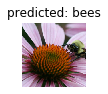

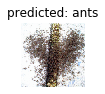

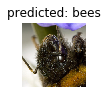

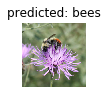

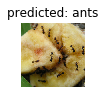

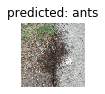

In [31]:
# 评估
visualize_model(model_conv)

plt.ioff()
plt.show()

In [33]:
# 也可以看到fine-turning的效果一般来说优于feature-based的方式，但后者在计算资源不足时也是非常好的方法。